# Bayesian Logistic Regression with Feature Engineering for Pima Diabetes Data Set

We perform logistic regression with feature engineering and mean-zero Gaussian prior for the 8-dimensional *Pima diabetes data set*, as can be retrieved from [Kaggle](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database), normalized so that each feature has sample mean zero and sample variance one. Specifically, we append all two-way interactions between given features to the data. That is, we replace every feature vector $v = (v_1,...v_{d_{\text{raw}}})^T$ in the original data by its augmented version

$$ 
(v_1,...,v_{d_{\text{raw}}}, v_1^2, v_1 v_2, v_2^2, ... , v_{d_{\text{raw}}-1} v_{d_{\text{raw}}}, v_{d_{\text{raw}}}^2, 1 ) \in \mathbb{R}^d ,
$$

so that we end up with $d = 45$.

Denote the augmented data set as $(a^{(i)},b^{(i)})_{i=1,...,n_{\text{data}}} \subset \mathbb{R}^d \times \{-1,1\}$, where $n_{\text{data}} = 768$.
Our prior is the mean-zero Gaussian $\mathcal{N}_d(0, \sigma^2 I_d)$ with $\sigma^2 = 100$. The likelihood is obtained by the usual logistic regression model. Our target density, the (unnormalized) posterior density, is therefore given by
$$
\varrho(x)
= \mathcal{N}_d(x; 0, \sigma^2 I_d) \prod_{i=1}^{n_{\text{data}}} \frac{1}{1 + \exp(-b^{(i)} \langle a^{(i)}, x \rangle)} , 
\quad x \in \mathbb{R}^d .
$$

In [1]:
from patt_mcmc import patt_ess, patt_gpss
from hit_and_run_uniform_slice_sampling import parallel_hruss
from random_walk_metropolis import parallel_ada_rwm
from generalized_elliptical_slice_sampling import two_group_gess
import stan_utils as su
import mcmc_utils as mcu
import plotting_functions as pfs

In [2]:
import pandas as pd
import numpy as np
import numpy.random as rnd
import time as tm
import matplotlib.pyplot as plt
import seaborn as sb

In [3]:
path_prefix = "../plots/BLR-FE_Pima_diabetes_"

### Retrieve and Prepare the Data, do Feature Engineering, Construct the Target Density

In [4]:
# load data set from file
data = pd.read_csv("../data/pima_diabetes.csv")
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [5]:
# retrieve features , do feature engineering
raw_feats = data.drop('Outcome', axis=1)
n_data = raw_feats.shape[0]
d_raw = raw_feats.shape[1]
# normalize features to mean zero and unit variance
medium_feats = ((raw_feats - raw_feats.mean()) / raw_feats.std()).to_numpy()
# do feature engineering (original data, two-way interactions, constant for intercept)
d = d_raw + (d_raw * (d_raw + 1) // 2) + 1
well_done_feats = np.zeros((n_data, d))
well_done_feats[:,:d_raw] = medium_feats
col = d_raw
for i in range(d_raw):
    for j in range(i+1):
        well_done_feats[:,col] = medium_feats[:,i] * medium_feats[:,j]
        col += 1
well_done_feats[:,col] = np.ones(n_data)
# use the resulting features for logistic regression
a = well_done_feats

In [6]:
# retrieve labels (1 = good, 2 = bad), map them to +-1
b = 2 * data['Outcome'].to_numpy() - 1

In [7]:
# set/retrieve some general parameters
d = a.shape[1]
sig_sq = 100 # prior variance

In [8]:
# construct posterior
def log_density(x):
    return - np.sum(x**2) / (2 * sig_sq) - np.sum(np.log(1 + np.exp(-b * np.inner(a, x))))

#### Special Treatment for Stan

In [9]:
stan_code = su.BLR_CODE
stan_data = su.blr_data(n_data, d, a, b, np.sqrt(sig_sq))

In [10]:
su.prevent_crashes(stan_code, stan_data)

Building: found in cache, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100% (1/1)
Sampling: 100% (1/1), done.
Messages received during sampling:
  Gradient evaluation took 5.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
  Adjust your expectations accordingly!
           performed for num_warmup < 20


### Run the Samplers

In running the samplers, we try to allocate each of them roughly the same computational budget. Regardless of how many iterations a sampler performs and how many parallel chains it uses, we ultimately judge it solely by its performance in the latter half of all of its chains.

Note: If either PATT-GPSS or GESS is run before HRUSS and AdaRWM, it can break the latter's progress bars, likely due to some sort of incompatibility between tqdm.tqdm and tqdm.notebook.tqdm.

In [11]:
n_chains = 10 # number of parallel chains permitted to each sampler (except GESS)
n_its = int(5e4) # total number of iterations per chain, per sampler (except AdaRWM, GESS)
x_0s = rnd.normal(size=(n_chains,d)) # suggested initial states

#### Hit-and-Run Uniform Slice Sampling

In [12]:
w_hruss = 1.0

In [13]:
samples_hruss, tde_hruss, times_hruss = parallel_hruss(log_density, n_chains, n_its, x_0s, w_hruss)

Checking validity of given arguments...
Preparing for parallel sampling...
Starting parallel sampling...


100%|███████████████████████████████████| 50000/50000 [00:19<00:00, 2630.28it/s]


Processing returns and terminating...


#### Adaptive Random Walk Metropolis
Note: We grant AdaRWM significantly more iterations than its competitors because it has a much lower computational cost per iteration (by virtue of only using one TDE per iteration) and we intend to grant the different samplers roughly the same computational budget.

In [14]:
n_its_rwm = 5 * n_its

In [15]:
samples_rwm, times_rwm, ldv_rwm, means_rwm, cov_rwm = parallel_ada_rwm(log_density, n_chains, n_its_rwm, x_0s)

Checking validity of given arguments...
Preparing for parallel sampling...
Starting parallel sampling...


100%|█████████████████████████████████| 250000/250000 [00:40<00:00, 6233.81it/s]


Processing returns and terminating...


In [16]:
tde_rwm = np.ones((n_its_rwm+1,n_chains), dtype=int)

In [17]:
# to conserve memory, we already summarize and then delete the means of RWM at this point
norms_rwm = mcu.get_radii(means_rwm)
del means_rwm

#### PATT Elliptical Slice Sampling

In [18]:
n_burn_ess = n_its // 10
n_its_ess = n_its - n_burn_ess

In [19]:
ret_dic = patt_ess(
    log_density,
    n_chains,
    n_burn_ess,
    n_its_ess,
    x_0s,
    cen_mode='mean',
    cov_mode='cov',
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/45001 [00:00<?, ?it/s]

Assembling output...


In [20]:
samples_ess = np.vstack([ret_dic['burn-in'], ret_dic['samples'][1:]])
tde_ess = np.vstack([ret_dic['tde_cnts_burn'], ret_dic['tde_cnts'][1:]])
times_ess = np.vstack([ret_dic['runtimes_burn'], ret_dic['runtimes'][1:]])
means_ess = ret_dic['means']
covs_ess = ret_dic['covs']
schedule_ess = ret_dic['schedule']

#### PATT Gibbsian Polar Slice Sampling

In [21]:
n_burn_gpss = n_its // 10
n_its_gpss = n_its - n_burn_gpss
w_burn = 1.0
w_att = 1.0

In [22]:
ret_dic = patt_gpss(
    log_density,
    n_chains,
    n_burn_gpss,
    n_its_gpss,
    x_0s,
    cen_mode='mean',
    cov_mode='cov',
    w_burn=w_burn,
    w_att=w_att,
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/45001 [00:00<?, ?it/s]

Assembling output...


In [23]:
samples_gpss = np.vstack([ret_dic['burn-in'], ret_dic['samples'][1:]])
tde_gpss = np.vstack([ret_dic['tde_cnts_burn'], ret_dic['tde_cnts'][1:]])
times_gpss = np.vstack([ret_dic['runtimes_burn'], ret_dic['runtimes'][1:]])
means_gpss = ret_dic['means']
covs_gpss = ret_dic['covs']
schedule_gpss = ret_dic['schedule']

#### Two-Group Generalized Elliptical Slice Sampling
Note: We grant GESS *way* more iterations than is appropriate with regards to our intent to allocate each method roughly the same computational budget. This is necessitated by GESS's demand for a very large number of chains on the one hand, and our desire to properly analyze the autocorrelation of each of these chains on the other hand.

In [24]:
n_chains_gess = max(2*d, n_chains)
n_its_gess = int(2e4)
x_0s_gess = rnd.normal(size=(2*n_chains_gess,d))

In [25]:
time_b = tm.time()
ret_dic = two_group_gess(log_density, n_chains_gess, 2 * n_its_gess, x_0s_gess, n_thr=n_chains)
time_a = tm.time()
total_time_gess = time_a - time_b

Checking validity of given arguments...
Preparing for parallel sampling...
Starting two-group sampling...


  0%|          | 0/40002 [00:00<?, ?it/s]

Assembling output...


In [26]:
samples_gess = ret_dic['samples']
tde_gess = ret_dic['tde_cnts']
schedule_gess = ret_dic['schedule']
dfs_G1, dfs_G2 = ret_dic['dfs']
centers_G1, centers_G2 = ret_dic['centers']
centers_gess = np.concatenate([centers_G1.reshape(-1,1,d), centers_G2.reshape(-1,1,d)], axis=1)
scale_G1, scale_G2 = ret_dic['scales']

#### Stan's NUTS

In [27]:
time_b = tm.time()
frames_stan, samples_stan, tge_stan, acc_rates_stan \
= su.sample_in_parallel(stan_code, stan_data, n_chains, n_its, x_0s)
time_a = tm.time()
total_time_stan = time_a - time_b

Building: found in cache, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Building: found in cache, done.
Building: found in cache, done.
Building: found in cache, done.
Building: found in cache, done.
Messages from stanc:
Messages from stanc:
Building: found in cache, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Building: found in cache, done.
Messages from stanc:
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this 

Sampling: 100% (51000/51000), done.
Sampling: 100% (51000/51000), done.
Messages received during sampling:
  Gradient evaluation took 4.3e-05 seconds
Messages received during sampling:
  1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
  Gradient evaluation took 4.3e-05 seconds
  Adjust your expectations accordingly!
  1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
  Adjust your expectations accordingly!
Messages received during sampling:
Messages received during sampling:
  Gradient evaluation took 5.6e-05 seconds
  Gradient evaluation took 6.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
  1000 transitions using 10 leapfrog steps per transition would take 0.64 seconds.
  Adjust your expectations accordingly!
  Adjust your expectations accordingly!
Sampling: 100% (51000/51000), done.
Sampling: 100% (51000/51000), done.
Messages received during sampling:
  Gradient evalua

In [28]:
frames_stan[0]

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,x.1,x.2,x.3,...,x.36,x.37,x.38,x.39,x.40,x.41,x.42,x.43,x.44,x.45
draws,,,,,,,,,,,,,,,,,,,,,
0,-349.746263,0.948624,0.195029,4.0,15.0,0.0,368.940930,0.287693,1.249798,0.079978,...,-0.083550,-0.091141,0.181958,0.503443,0.130415,0.073312,-0.127637,-0.347764,-0.490928,-0.636790
1,-351.612856,0.992461,0.195029,5.0,31.0,0.0,372.535129,0.598467,1.676277,-0.455157,...,-0.148182,-0.284985,-0.092934,1.101074,-0.243543,0.420052,-0.240468,-0.283548,-0.528953,-1.011643
2,-339.994420,1.000000,0.195029,5.0,31.0,0.0,368.889033,0.268080,1.413077,-0.281233,...,-0.063951,-0.428128,-0.157646,0.448646,0.009229,0.236885,0.085300,-0.320873,-0.289843,-1.078725
3,-346.336520,0.903855,0.195029,4.0,31.0,0.0,364.156895,0.321550,1.259233,-0.245606,...,-0.018855,-0.738446,-0.147840,0.600576,0.054869,0.527884,-0.134842,-0.250450,-0.376211,-0.469307
4,-339.656229,0.905104,0.195029,5.0,31.0,0.0,363.825399,0.263498,1.539094,-0.362378,...,0.040301,-0.311238,-0.170320,0.585108,-0.180367,0.337371,0.018058,-0.303225,-0.294443,-1.202344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,-343.445615,0.901673,0.195029,5.0,31.0,0.0,365.474309,0.317713,1.765584,-0.243873,...,-0.143411,-0.319853,-0.170255,0.356075,0.286671,0.221516,-0.246144,-0.275308,-0.278639,-0.552087
49996,-346.426932,0.975366,0.195029,5.0,31.0,0.0,359.539779,0.257817,1.319039,-0.353457,...,-0.084837,-0.330570,-0.045890,0.528486,-0.188947,0.299386,-0.271323,-0.215948,-0.465318,-0.727112
49997,-340.473890,0.925932,0.195029,5.0,31.0,0.0,368.817329,0.351059,1.561367,-0.329463,...,-0.076033,-0.620019,-0.419180,0.336782,0.212022,0.442851,-0.019426,-0.306398,-0.171297,-0.887793


### Analyze Sampling Performance

In [29]:
snames = ["PATT-ESS", "PATT-GPSS", "HRUSS", "AdaRWM", "GESS", "Stan's NUTS"]
nsam = len(snames)
full_samples = [samples_ess, samples_gpss, samples_hruss, samples_rwm, samples_gess, samples_stan]
full_tde = [tde_ess, tde_gpss, tde_hruss, tde_rwm, tde_gess, tge_stan]
full_times = [times_ess, times_gpss, times_hruss, times_rwm, None, None] # this list...
full_total_times = [None, None, None, None, total_time_gess, total_time_stan] # ...should complement this list
n_chains_all = np.full(nsam, n_chains)
n_chains_all[4] = n_chains_gess # make sure index 4 <-> GESS!
n_its_all = np.array([n_its, n_its, n_its, n_its_rwm, n_its_gess, n_its], dtype=int)
n_burns = n_its_all // 2
n_late_its = n_its_all - n_burns
n_late_samples = n_chains_all * n_late_its

In [30]:
burn_samples = [fs[:nb] for fs, nb in zip(full_samples, n_burns)]
samples = [fs[nb:] for fs, nb in zip(full_samples, n_burns)]
burn_tde = [ft[:nb] for ft, nb in zip(full_tde, n_burns)]
tde = [ft[nb:] for ft, nb in zip(full_tde, n_burns)]
burn_times = [ft[:nb] if type(ft) != type(None) else None for ft, nb in zip(full_times, n_burns)]
times = [ft[nb:] if type(ft) != type(None) else None for ft, nb in zip(full_times, n_burns)]
full_radii = mcu.get_radii_list(full_samples)
burn_radii = mcu.get_radii_list(burn_samples)
radii = mcu.get_radii_list(samples)
flat_steps = mcu.get_flat_steps_list(samples)
pos_mean_ests = [np.mean(sams, axis=(0,1)) for sams in samples]

In [31]:
# collect total runtimes taken by each sampler for the "late" iterations
total_times = np.zeros(nsam)
for i in range(nsam):
    if type(times[i]) != type(None):
        total_times[i] = np.mean(np.sum(times[i], axis=0))
    else:
        total_times[i] = full_total_times[i] * (n_late_its[i] / n_its_all[i])

In [32]:
mean_burn_tde = mcu.mean_tde_list(burn_tde)
mean_tde = mcu.mean_tde_list(tde)
sams_per_s = n_late_samples / total_times
maxls = [1000, 1000, 5000, 5000, int(1e4), 1000]
mean_iats = mcu.mean_iat_multi_chain_list(samples, maxls)
msss = mcu.mss_list(samples)
tde_per_es = mean_tde * mean_iats # TDE/ES = total TDE / total ES = TDE/it / ES/it = TDE/it * IAT
es_per_s = sams_per_s / mean_iats # ES/s = total ES / total time = (total samples / IAT) / total time = samples/time / IAT
accuracy = lambda coef: np.mean(np.sign(np.inner(a, coef)) == b)
accuracies = [accuracy(pme) for pme in pos_mean_ests]

In [33]:
pd.DataFrame(
    np.array([
        snames,
        np.round(mean_burn_tde, 2),
        np.round(mean_tde, 2),
        np.array(sams_per_s, dtype=int),
        np.round(mean_iats, 2),
        np.round(msss, 2),
        np.round(tde_per_es, 2),
        np.round(es_per_s, 2),
        np.round(mean_tde / msss, 2), # = TDE/it * (its to move by 1) = TDE to move by 1
        np.round(accuracies, 3),
    ]).T,
    columns = [
        "Sampler",
        "Burn-In TDE/it",
        "TDE/it",
        "Samples/s",
        "Mean IAT",
        "MSS",
        "TDE/ES",
        "ES/s",
        "TDE/MSS",
        "Accuracy",
    ]
)

,Sampler,Burn-In TDE/it,TDE/it,Samples/s,Mean IAT,MSS,TDE/ES,ES/s,TDE/MSS,Accuracy
0,PATT-ESS,4.1,2.01,24200,2.93,1.05,5.88,8259.59,1.91,0.799
1,PATT-GPSS,9.2,7.7,13803,2.48,1.08,19.11,5564.14,7.13,0.799
2,HRUSS,5.41,5.43,28600,613.58,0.09,3331.42,46.61,62.38,0.801
3,AdaRWM,1.0,1.0,66163,420.16,0.05,420.16,157.47,20.67,0.801
4,GESS,10.21,8.85,5754,1374.96,0.07,12170.44,4.19,123.22,0.792
5,Stan's NUTS,29.53,29.53,5552,1.01,1.57,29.8,5502.3,18.85,0.799


### Plotting

In [34]:
n_win = int(1e4)

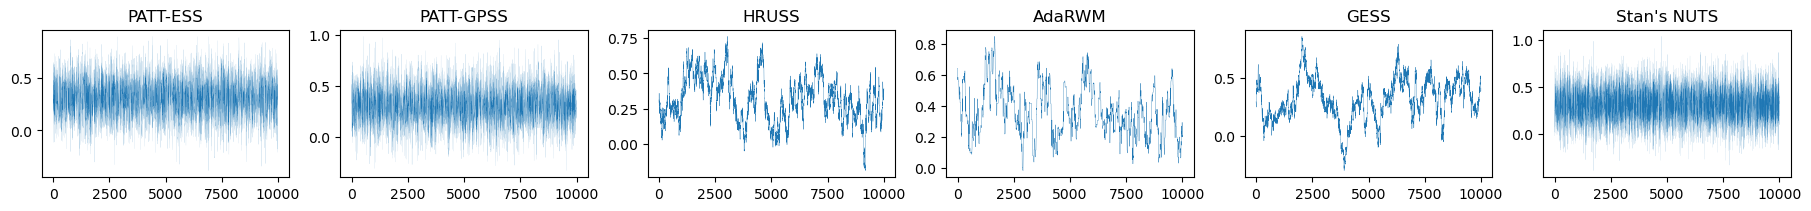

In [35]:
lws = [0.05, 0.05, 0.25, 0.25, 0.25, 0.05]
path = path_prefix + "marginal_trace.png"
pfs.trace_plot_row([sams[-n_win:,0,0] for sams in samples], snames, filepath=path, lws=lws)

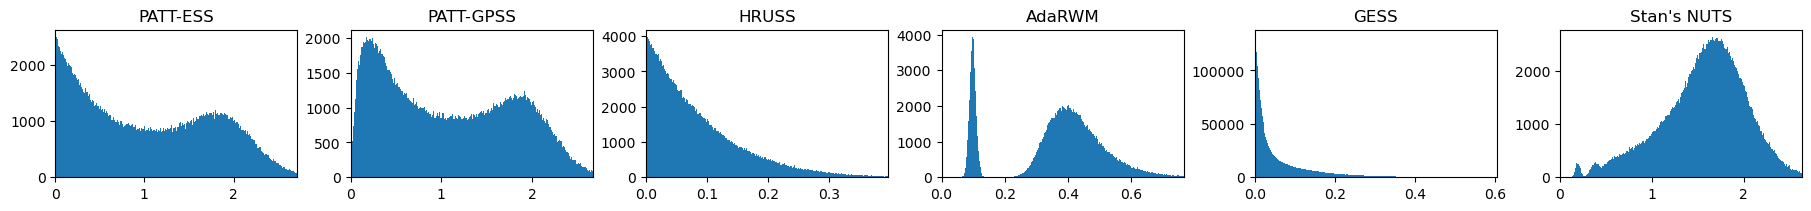

In [36]:
plot_steps = [np.copy(fs) for fs in flat_steps]
plot_steps[3] = plot_steps[3][plot_steps[3] != 0.0]
path = path_prefix + "steps.png"
pfs.plot_step_hist_row(plot_steps, snames, filepath=path)

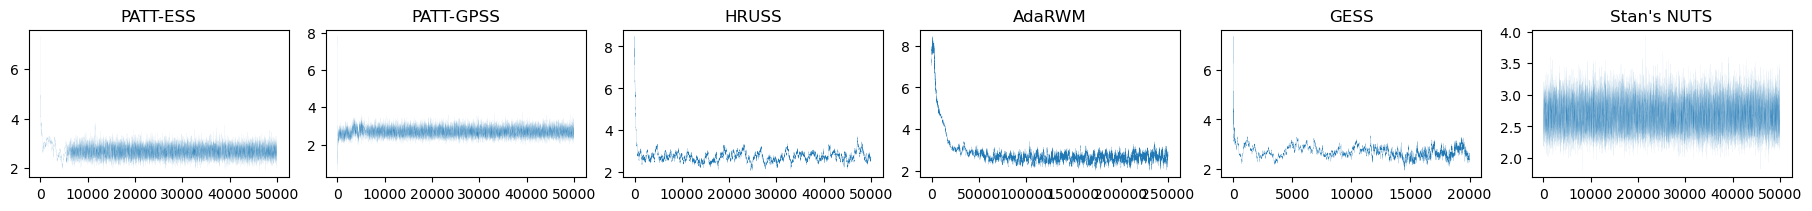

In [37]:
lws = [0.025, 0.025, 0.1, 0.1, 0.1, 0.025]
pfs.trace_plot_row([frs[:,0] for frs in full_radii], snames, lws=lws)

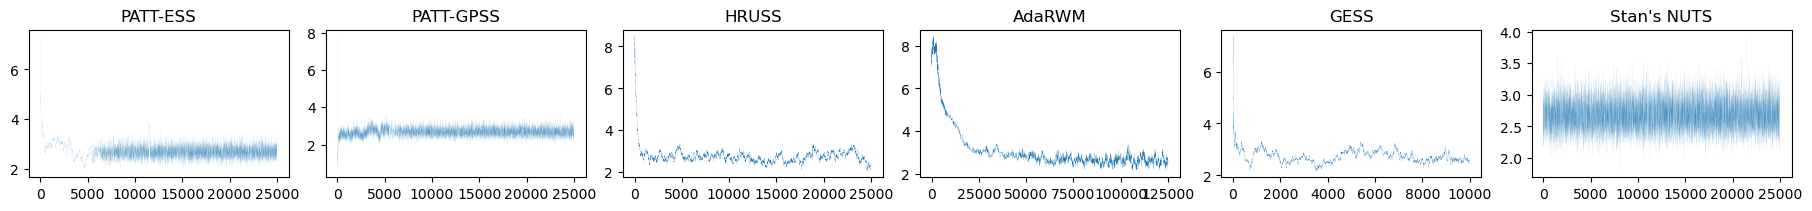

In [38]:
pfs.trace_plot_row([brs[:,0] for brs in burn_radii], snames, lws=lws)

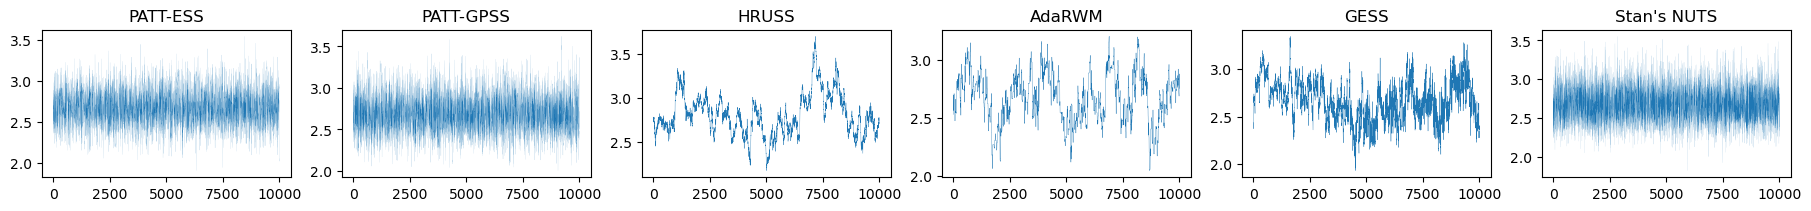

In [39]:
lws = [0.05, 0.05, 0.25, 0.25, 0.25, 0.05]
pfs.trace_plot_row([rs[-n_win:,0] for rs in radii], snames, lws=lws)

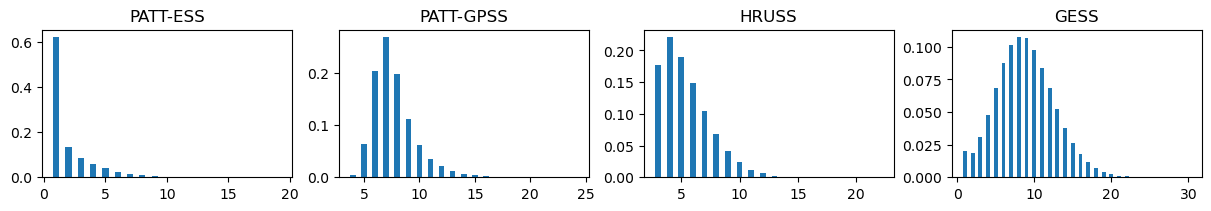

In [40]:
tde_inds = [0,1,2,4]
pfs.plot_tde_distr_row([tde[i] for i in tde_inds], [snames[i] for i in tde_inds])

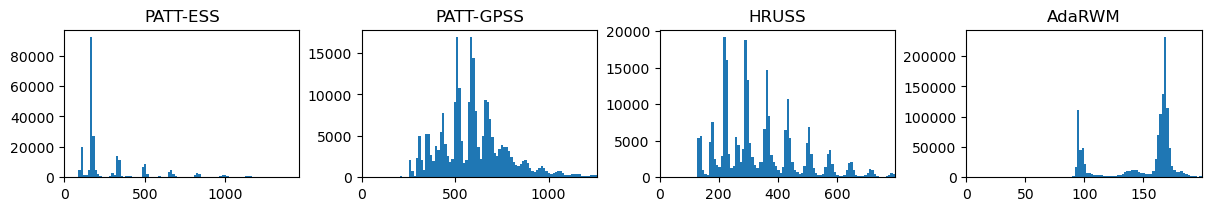

In [41]:
granular_times = [0,1,2,3]
pfs.plot_runtime_hist_row([times[i] for i in granular_times], 
                          [snames[i] for i in granular_times], nbins=100, cutoff_quant=0.99)

In [42]:
acc_rates_rwm = np.mean(ldv_rwm[n_its_rwm//2+1:] != ldv_rwm[n_its_rwm//2:-1], axis=0)
print("Average AdaRWM acceptance rate: {:.3f}".format(np.mean(acc_rates_rwm)))
print("Minimal AdaRWM acceptance rate: {:.3f}".format(np.min(acc_rates_rwm)))
print("Maximal AdaRWM acceptance rate: {:.3f}".format(np.max(acc_rates_rwm)))

Average AdaRWM acceptance rate: 0.133
Minimal AdaRWM acceptance rate: 0.106
Maximal AdaRWM acceptance rate: 0.164


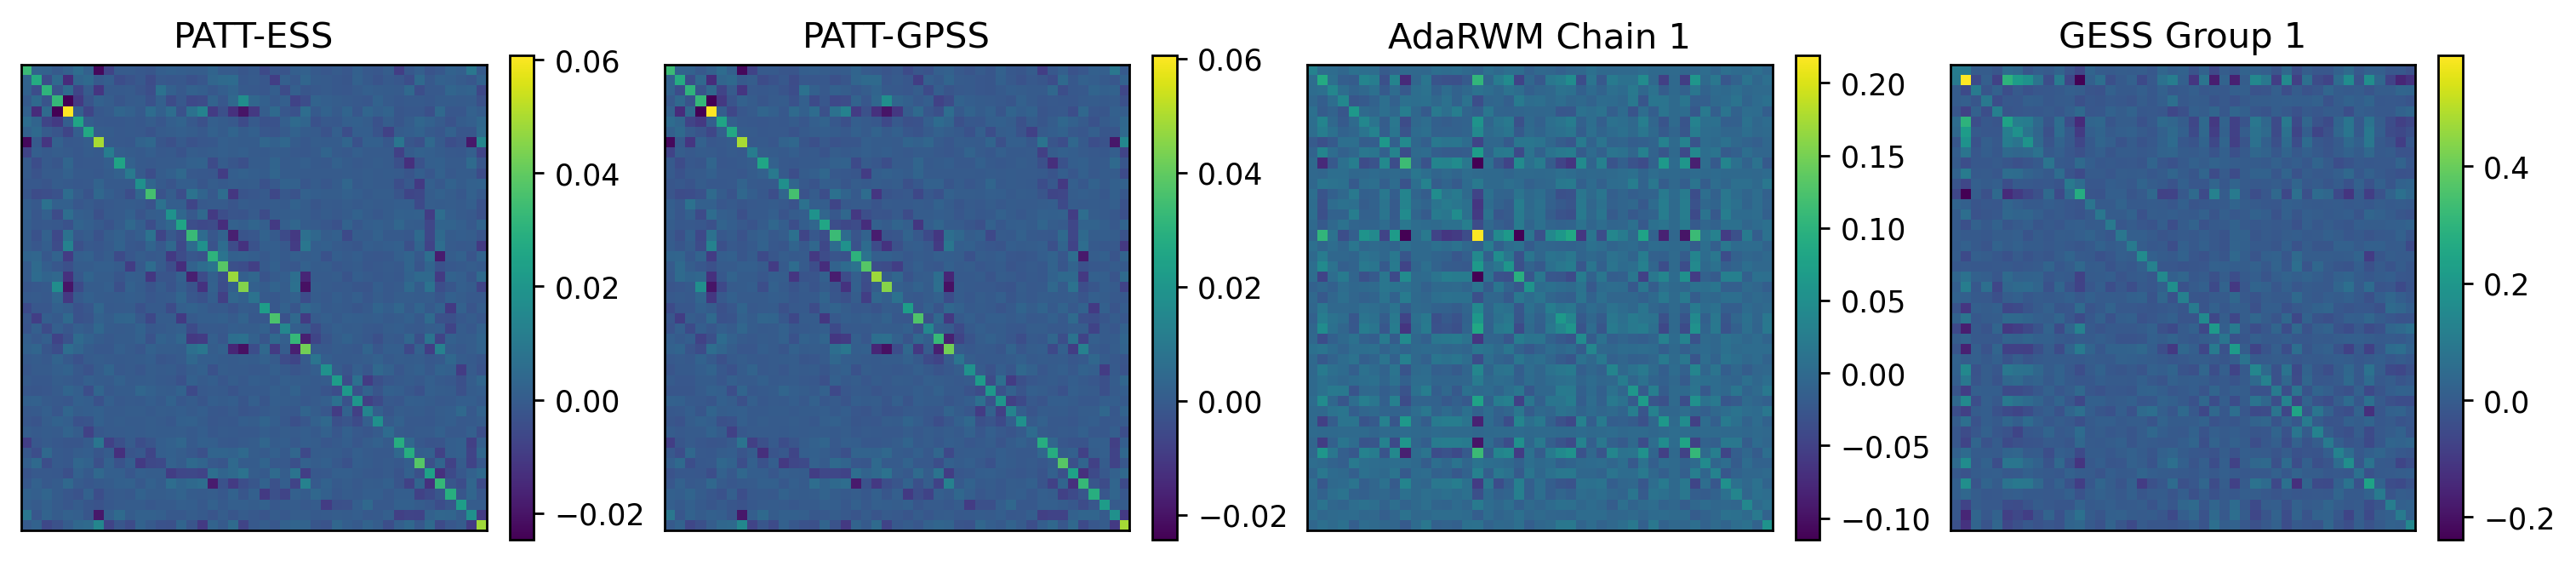

In [43]:
titles = ["PATT-ESS", "PATT-GPSS", "AdaRWM Chain 1", "GESS Group 1"]
covs = [covs_ess[-1], covs_gpss[-1], cov_rwm[0], scale_G1]
path = path_prefix + "covs.png"
pfs.plot_covs_row(covs, titles, filepath=path, shrink=0.78)

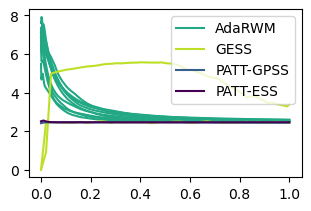

In [44]:
# plot progressions of the norm of each sampler's posterior mean approximation
norms_ess = mcu.get_radii(means_ess)
norms_gpss = mcu.get_radii(means_gpss)
norms_gess = mcu.get_radii(centers_gess)
colors = plt.cm.viridis(np.linspace(0, 0.9, 4))
pfs.initiate((3,2),100)
plt.plot(np.linspace(0,1,n_its_rwm+1), norms_rwm[:,0], color=colors[2], label=snames[3])
for i in range(1,n_chains):
    plt.plot(np.linspace(0,1,n_its_rwm+1), norms_rwm[:,i], color=colors[2])
plt.plot(schedule_gess / schedule_gess[-1], norms_gess[:,0], color=colors[3], label=snames[4])
plt.plot(schedule_gess / schedule_gess[-1], norms_gess[:,1], color=colors[3])
plt.plot(schedule_gpss / schedule_gpss[-1], norms_gpss, color=colors[1], label=snames[1])
plt.plot(schedule_ess / schedule_ess[-1], norms_ess, color=colors[0], label=snames[0])
plt.legend(loc='upper right')
pfs.wrapup()

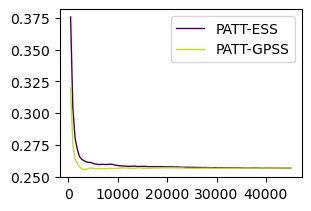

In [45]:
# plot progressions of the norm of the PATT samplers' posterior covariance approximations
cov_norms_ess = mcu.get_radii(covs_ess.reshape(schedule_ess.shape[0],-1))
cov_norms_gpss = mcu.get_radii(covs_gpss.reshape(schedule_gpss.shape[0],-1))
colors = plt.cm.viridis(np.linspace(0, 0.9, 2))
pfs.initiate((3,2),100)
plt.plot(schedule_ess[1:], cov_norms_ess[1:], color=colors[0], linewidth=1)
plt.plot(schedule_gpss[1:], cov_norms_gpss[1:], color=colors[1], linewidth=1)
plt.legend(snames[:2])
pfs.wrapup()

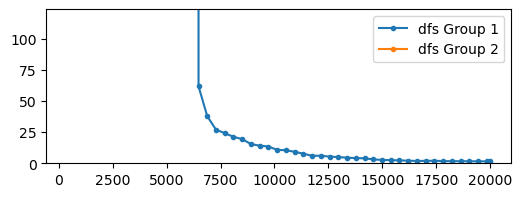

In [46]:
plt.figure(figsize=(6,2))
for dfs in [dfs_G1, dfs_G2]:
    plt.plot(schedule_gess[1:], dfs[1:], marker='.')
plt.legend(["dfs Group {}".format(i+1) for i in range(2)])
plt.ylim((0,2*np.max(np.concatenate([dfs_G1[dfs_G1 != 1e6], dfs_G2[dfs_G2 != 1e6]]))))
plt.show()

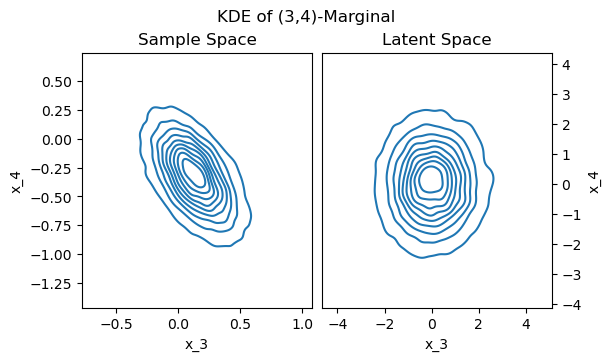

In [47]:
# plot a bivariate marginal KDE in sample space and (PATT-ESS's final) latent space
inds = [3,4]
ax_labels = ["x_{}".format(inds[0]), "x_{}".format(inds[1])]
fig, axes = plt.subplots(1,2, figsize=(6,3.5), dpi=100, constrained_layout=True)
fig.suptitle("KDE of ({},{})-Marginal".format(inds[0], inds[1]))
# left column: bivariate marginal in sample space
axes[0].set_title("Sample Space")
biv_sample_sp = np.concatenate([samples[0][:,0,inds[0]].reshape(-1,1),
                                samples[0][:,0,inds[1]].reshape(-1,1)], axis=1)
biv_sample_sp_frame = pd.DataFrame(biv_sample_sp, columns=ax_labels)
sb.kdeplot(biv_sample_sp_frame, x=ax_labels[0], y=ax_labels[1], ax = axes[0])
# right column: bivariate marginal in latent space
axes[1].set_title("Latent Space")
L = np.linalg.cholesky(covs_gpss[-1])
L_inv = np.linalg.inv(L)
alpha_inv = lambda y: L_inv @ (y - means_gpss[-1])
plot_latent_samples = np.apply_along_axis(alpha_inv, -1, samples[0][:,0])
biv_latent_sp = np.concatenate([plot_latent_samples[:,inds[0]].reshape(-1,1),
                                plot_latent_samples[:,inds[1]].reshape(-1,1)], axis=1)
biv_latent_sp_frame = pd.DataFrame(biv_latent_sp, columns=ax_labels)
sb.kdeplot(biv_latent_sp_frame, x=ax_labels[0], y=ax_labels[1], ax = axes[1])
axes[1].yaxis.tick_right()
axes[1].yaxis.set_label_position("right")
pfs.wrapup()

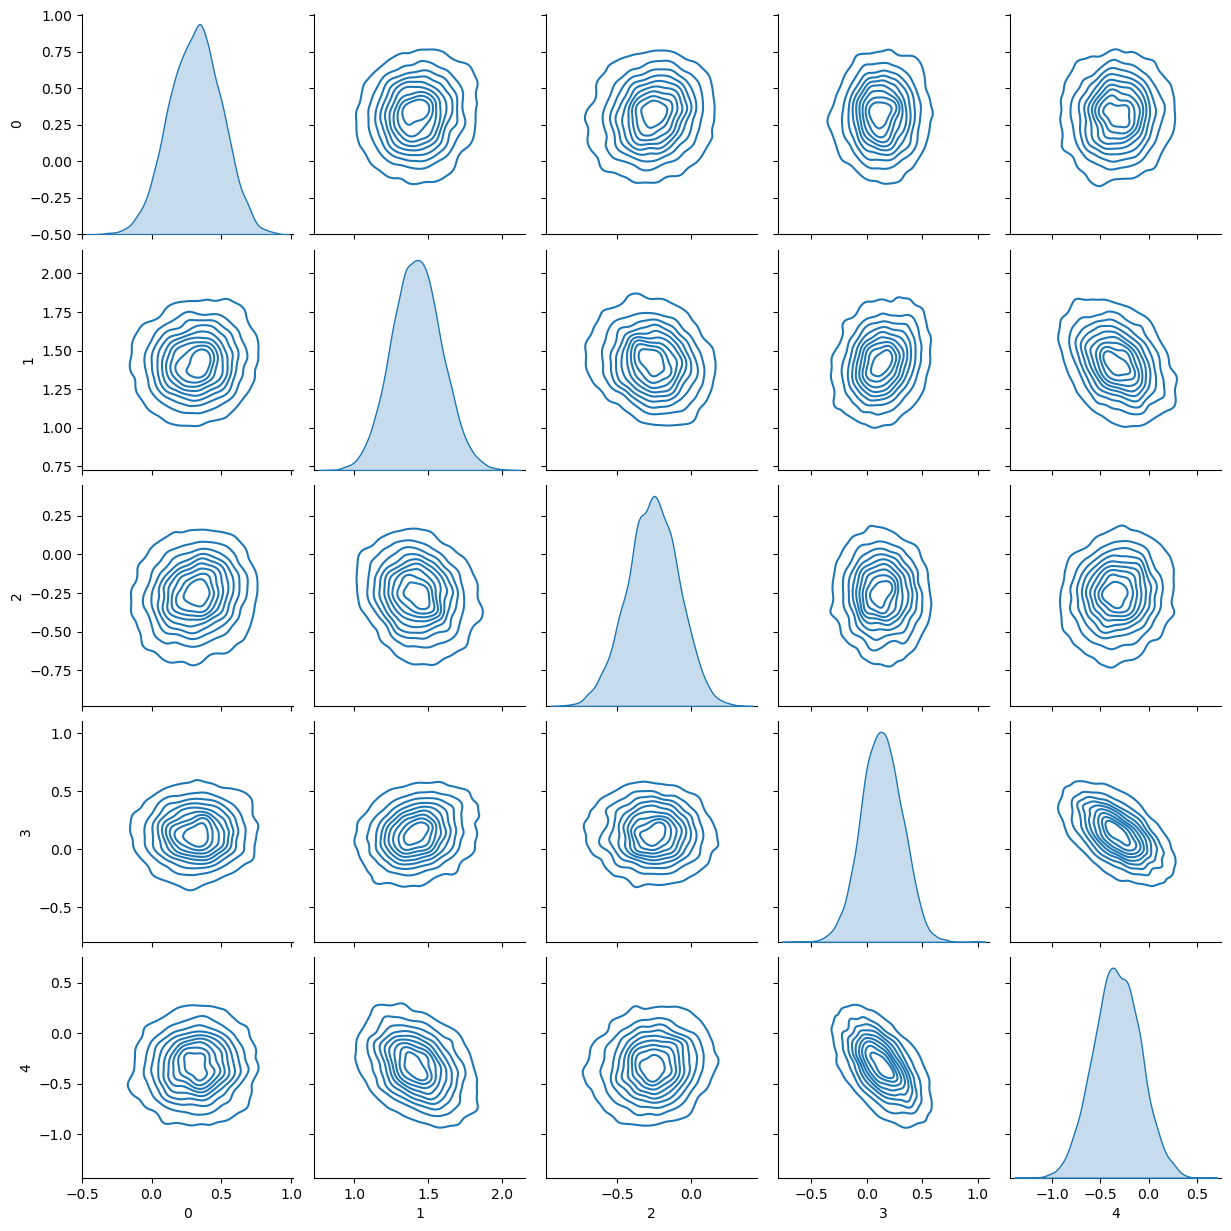

In [48]:
# this cell may take 1-2 min to run
sb.pairplot(pd.DataFrame(samples[0][-n_win:,0,:5]), kind='kde')
plt.show()

In [49]:
pos_mean_ests[0]

array([ 0.3100755 ,  1.42570123, -0.2572312 ,  0.12695083, -0.32526705,
        0.71096908,  0.60440568,  0.63750768,  0.2195079 , -0.21526967,
        0.20622807, -0.18990796, -0.33770684, -0.03370236,  0.09864794,
       -0.08152504, -0.06828649, -0.01675512,  0.0233701 , -0.03415335,
        0.22856193,  0.28358588,  0.0342503 , -0.21433957,  0.02105975,
       -0.02966348, -0.01330175, -0.27001848,  0.02834337,  0.26019358,
       -0.0865089 , -0.14428101,  0.40097476, -0.20587296, -0.08544224,
       -0.10479308, -0.3869334 , -0.11320014,  0.62782082, -0.00842498,
        0.29471243, -0.15588679, -0.23354373, -0.41849382, -0.80279468])